In [15]:
"""
Example of running a simulation with two batteries of different initial SOC.
"""

import liionpack as lp
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import textwrap

In [20]:
lp.logger.setLevel("NOTICE")

# Define parameters
Np = 2
Ns = 1
Iapp = 5

# Generate the netlist and output variables
netlist = lp.setup_circuit(Np=Np, Ns=Ns, Rb=1.5e-3, Rc=1e-2, Ri=5e-2, V=4.0, I=Iapp)
output_variables = [
    "Negative electrode SOC",
    "Positive electrode SOC",
]

# Cycling experiment
experiment = pybamm.Experiment(
    [
        f"Charge at {Iapp} A for 30 minutes",
        "Rest for 15 minutes",
        f"Discharge at {Iapp} A for 30 minutes",
        "Rest for 30 minutes",
    ],
    period="10 seconds",
)

# PyBaMM parameters
param = pybamm.pybamm.ParameterValues("Chen2020")

c_s_n_init, c_s_p_init = lp.update_init_conc(
    param, SoC=np.array([0.4, 0.7]), update=False
)

param.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": "[input]",
        "Initial concentration in positive electrode [mol.m-3]": "[input]",
    }
)

inputs = {
    "Initial concentration in negative electrode [mol.m-3]": c_s_n_init,
    "Initial concentration in positive electrode [mol.m-3]": c_s_p_init,
}

# Solve pack
output = lp.solve(
    netlist=netlist,
    parameter_values=param,
    experiment=experiment,
    output_variables=output_variables,
    initial_soc=None,
    inputs=inputs,
)

2022-02-10 16:09:10,625 - [NOTICE] netlist_utils.setup_circuit(333): Circuit created
2022-02-10 16:09:10 - [NOTICE] netlist_utils.setup_circuit(333): Circuit created
2022-02-10 16:09:10,766 - [NOTICE] solvers.check_current_function(285): Parameter: Current function [A] has been set to input
2022-02-10 16:09:10 - [NOTICE] solvers.check_current_function(285): Parameter: Current function [A] has been set to input
2022-02-10 16:09:11,210 - [NOTICE] solvers.solve(206): Starting step solve
2022-02-10 16:09:11 - [NOTICE] solvers.solve(206): Starting step solve
Stepping simulation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 631/631 [00:02<00:00, 238.29it/s]
2022-02-10 16:09:13,861 - [NOTICE] solvers.solve(258): Step solve finished
2022-02-10 16:09:13 - [NOTICE] solvers.solve(258): Step solve fini

Plot

2022-02-10 16:11:28,125 - [WARNING] backend_ps._is_transparent(303): The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2022-02-10 16:11:28 - [WARNING] backend_ps._is_transparent(303): The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


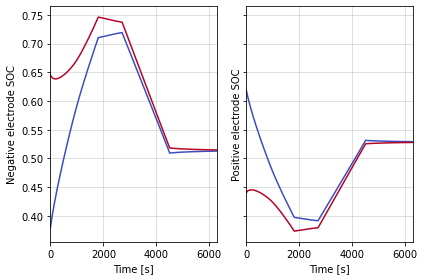

In [24]:

# Get time and results for battery cells
time = output["Time [s]"]
cell_vars = ["Negative electrode SOC", "Positive electrode SOC"]

context = "light"
context = lp.lp_context(context)
cmap = lp.lp_cmap(context)

# Get number of cells and setup colormap
n = output[cell_vars[0]].shape[-1]
colors = cmap(np.linspace(0, 1, n))

# Create plot figures for cell variables
fig, axes = plt.subplots(1,2,tight_layout=True,sharex=True,sharey=True)
with plt.rc_context(context):
    for j, var in enumerate(cell_vars):
        ax = axes[j]
        for i in range(n):
            ax.plot(time, output[var][:, i], color=colors[i])
        ax.set_xlabel("Time [s]")
        ax.set_ylabel(textwrap.fill(var, 45))
        ax.ticklabel_format(axis="y", scilimits=[-5, 5])
        ax.set_xlim([0,time[-1]])
        ax.grid(alpha=0.5)
        
    fig.savefig("../figures/different_soc.eps",dpi=1000)
    fig.savefig("../figures/different_soc.pdf")